## Protein Embeddings Manipulation

In [1]:
from pathlib import Path

data_path = Path("../data/Protera") 

!ls $data_path

clustering
cluster.out
data.csv
mmseq
mmseq_q
mmseq_t
prefilter.out
prism
search.out
sequences.fasta
stability.csv
stability_embeddings_test.pkl
stability_embeddings_train.pkl
stability_prism_merged_030_HMGCR_yeast_complementation_control_medium.h5
stability_prism_merged_037_UBI4_E1_binding_limiting_E1.h5
stability_test.csv
stability_test_diversity.csv
stability_test.h5
stability_train.csv
stability_train_diversity.csv
stability_train.h5
stability_with_dups.csv
tmp


In [2]:
from pathlib import Path
import matplotlib.pyplot as plt

from protera_stability.data import ProteinStabilityDataset

### Get Dataset

In [3]:
train_set = ProteinStabilityDataset(proteins_path=data_path / "stability_train.h5")
test_set =  ProteinStabilityDataset(proteins_path=data_path / "stability_test.h5")
len(train_set), len(test_set)

(32001, 7999)

In [4]:
train_set.X.mean(), train_set.X.var(), train_set.X.shape

(-1.5524662e-10, 0.9999989, (32001, 1280))

In [5]:
train_set.y.mean(), train_set.y.var(), train_set.y.shape

(7.629156e-09, 0.99999994, (32001,))

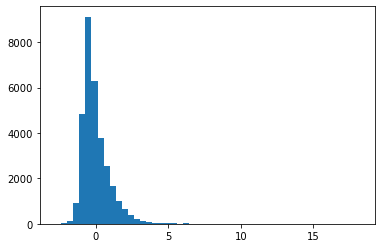

In [6]:
plt.hist(train_set.y, bins=50)
plt.show()

## Can a FeedForward Net do better?


In [7]:
from torch import nn
import torch

class ProteinMLP(nn.Module):
    def __init__(self, n_in = 1280, n_units = 2048, emb_dim = 1024, act = None, drop_p = 0.7, last_drop = True):
        super(ProteinMLP, self).__init__()
        self.fc1 = nn.Linear(n_in, n_units)
        self.fc2 = nn.Linear(n_units, n_units)
        self.new_emb = nn.Linear(n_units, emb_dim)
        self.fc3 = nn.Linear(emb_dim, 1)
        
        self.drop = nn.Dropout(p=drop_p)
        self.bn1 = nn.BatchNorm1d(n_units)
        self.bn2 = nn.BatchNorm1d(n_units)


        self.last_drop = last_drop
        self.act = act
        if act is None:
            self.act = nn.ReLU6()
            
    def forward(self, x):
        out = self.drop(self.act(self.fc1(x)))
        out = self.drop(self.act(self.fc2(out)))
        out = self.act(self.new_emb(out))
        
        if self.last_drop: 
            out = self.drop(out)
        return self.fc3(out)

In [8]:
from skorch.callbacks import Checkpoint, LRScheduler, EarlyStopping
from skorch import NeuralNetRegressor

cb = Checkpoint(dirname='models')
sched = LRScheduler(step_every="epoch")
stopper = EarlyStopping(patience=15)

net = NeuralNetRegressor(
    ProteinMLP,
    criterion=nn.MSELoss,
    # optimizer=torch.optim.Adam,
    # optimizer__momentum=0.05,
    optimizer__weight_decay=1e-2,
    max_epochs=int(1e4),
    lr=3e-3,
    iterator_train__shuffle=True,
    device='cuda:1',
    callbacks=[cb, sched, stopper],
)

net.fit(train_set.X, train_set.y.reshape(-1,1))

net.score(test_set.X, test_set.y)

  epoch    train_loss    valid_loss    cp      lr     dur
-------  ------------  ------------  ----  ------  ------
      1        1.0053        0.9510     +  0.0500  1.1828
      2        0.8869        0.8831     +  0.0488  0.9344
      3        0.8410        0.8521     +  0.0452  0.9265
      4        0.8073        0.8326     +  0.0397  0.9392
      5        0.7902        0.8149     +  0.0327  0.9513
      6        0.7633        0.7984     +  0.0250  0.9676
      7        0.7558        0.7941     +  0.0173  0.9904
      8        0.7425        0.7762     +  0.0103  0.9669
      9        0.7360        0.7716     +  0.0048  0.9654
     10        0.7255        0.7674     +  0.0012  0.9482
     11        0.7188        0.7674     +  0.0000  0.9341
     12        0.7669        0.7888        0.0500  0.9213
     13        0.7627        0.7972        0.0497  0.9311
     14        0.7569        0.7863        0.0488  0.9463
     15        0.7526        0.7667     +  0.0473  0.9566
     16       

0.2988250051834447